In [1]:
# General stuff
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Ellipse
import pickle

# Astropy stuff
from astropy.io import fits, ascii
from astropy.visualization import simple_norm  # this will come in handy to visualize images
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import table
import astropy.units as u

# For calculating flux
import sep

# Fitting stuff
from scipy import stats
from scipy.optimize import curve_fit
import General_functions as my

# For convolving
import warnings
from astropy.modeling.models import Sersic2D
from scipy.signal import fftconvolve as fft

# For creating loading bars
from tqdm.notebook import tqdm

# Introduction

This notebook runs SEP on the IRAC channel 1 tile 7-7 and saves the pickled file with the cleaned image along with the table of all the information from the findings. 

We will use this to create a combined model of the image that we can later subtract from the telescope image.

# Loading the image

In [2]:
# For loading images
def open_img(filename, hdu=0):
    
    if filename[-5:] == '.fits':  
        # if last 5 characters of the string are '.fits', the file is interpreted as FITS file
        hdul = fits.open(filename)  # open the HDU list of a FITS file 
                                    # (it may contain multiple data sets called Header Data Units)
            
        img = hdul[hdu].data  # save data from the unit n. 1 (or whatever is the `hdu` nuber) into `img` array
        hdr = hdul[hdu].header  # we may need also the header, which contain info about the image/data set
        # .header
        hdul.close()  # close the FITS file
        
    else:
        # if not FITS file, the function complains because it doesn't know other ways to do
        sys.exit("ERROR: open_img can deal with FITS file only.")
        
    return img, hdr  # the output is a tuple of two different objects

In [3]:
img, header = open_img('Resources/IRAC-ch1_tile_7-7.fits', hdu=0)

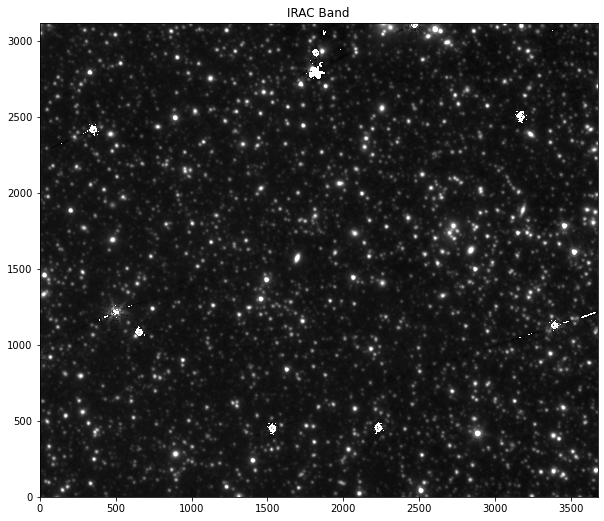

In [4]:
# For visualising the images before manipulating them
def img_plot(img, ax, title=None):
    
    #Normalise
    normal = simple_norm(img,stretch='sqrt', percent=99.5)
    
    # Plot
    ax.imshow(img, cmap='gray', origin='lower', norm=normal)
    ax.set_title(title)

# Lets plot the files
fig, ax = plt.subplots(figsize=(10,10))
img_plot(img, ax, title='IRAC Band')

# Loading the PSF

In [5]:
PSF, PSF_hdr = open_img('Resources/PSF_IRAC_ch1_7-7_gp25250.fits', hdu=0)

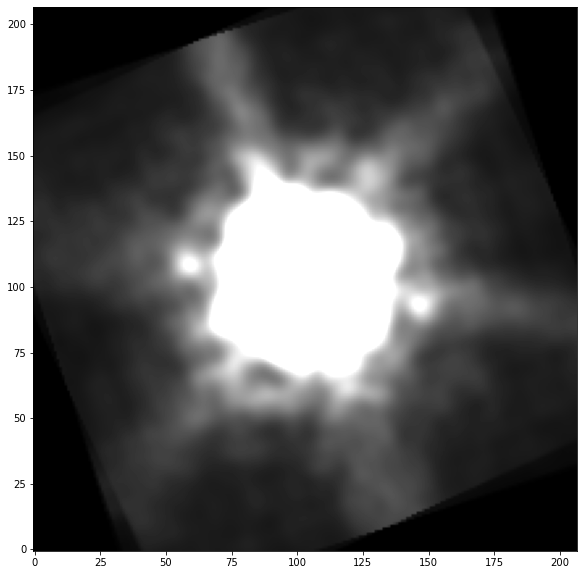

In [6]:
# Lets plot the files
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(PSF, cmap='gray', origin='lower', vmin=0, vmax=1e-5)

# Define the class we made in the previous notebook to model sources

In [7]:
class Sersic_Model(Sersic2D):
    """
    The class takes the models.Sersic2D class from astropy as its base
    
    To produce a point source model:
    the method point_source is used. This used the flux from the catalogue to scale the PSf appropriately.
    
    For all other models:
    first the method profile is used to produce the sersic profile according to paramters from the catalogue.
    Second the method convolve is used, which convolves the intrinsic light profile with the PSF and scales
    it to match the flux from the catalogue. 
    """
    
    def __init__(self, psf, pix_size=0.15): #psf):
        """
        Specify the PSF to be convolved with the Sersic2D model, to instantiate the class. Notice the size 
        of the PSF will be the size of the model we want to create later
        """
        
        self.pix_size = pix_size # save the pixelsize
        self.psf = psf / np.sum(psf) #normalise it so flux is only redistributed
    
    def point_source(self, cat_flux, img_m0 = 21.58, cat_m0=23.9, size=207):
        
        # Find the flux of the PSF
        integrated_r = 60 # we itnegrate within a circle of 10 pixels = 7.5 arcseconds
        mid_pix = np.shape(self.psf)[0] // 2 + 1 # assumes a square PSF, shared center for x and y
        PSF_flux, _, _ = sep.sum_circle(self.psf, np.array([mid_pix]), np.array([mid_pix]), integrated_r, gain=None)
        
        # Expected flux in native units 
        native_flux = 10**( (1/(-2.5)) * (-2.5*np.log10(cat_flux)+cat_m0-img_m0))
        
        # Amplitude to scale the PSF accordingly
        A = native_flux / PSF_flux
        
        # Combined model is thus the scaled PSF
        model = A * self.psf
        
        # Resize model to desired cutout size
        half_size = size//2
        xlow, xhigh = int(mid_pix-1 - half_size), int(mid_pix-1 + half_size)
        ylow, yhigh = int(mid_pix-1 - half_size), int(mid_pix-1 + half_size)
        model = model[ylow:yhigh+1, xlow:xhigh+1]
        
        # Save model and model type to the object
        self.model = model
        self.model_type = 'PointSource'
        
    def profile(self, solution_model, params, img_m0 = 21.58, cat_m0=23.9, size=207):
        """
        This method allows us to assign the object (self) with the parameters needed to create the
        intrinsic profile modelled with a sersic profile. Is called by objectname.profile.
        
        psf_m0 = image zero magnitude: is this still right when we normalise the psf?
        """
        
        # Assert which model is used, so we can see it later if needed
        self.model_type = solution_model
        
        # Find center pixel
        mid_pix = np.shape(self.psf)[0] // 2 + 1
        
        # Depending on the model used, different parameters are constant and n might take on other values
        if solution_model == 'SimpleGalaxy':
            
            # Fixed parameters for this profile
            n = 1 # exponential profile
            R_eff = 0.45 / self.pix_size # 0.45 fixed arcsecond effective radius
            ell, angle = 0, 0 #symmetry gives no angle or ellipticity
            
            # Extract remaining parameters for .evaluate
            x0, y0, cat_flux = params[0], params[1], params[2]
            
            # Save center coordinates to the object
            self.x0, self.y0 = x0, y0
            
        if solution_model == 'ExpGalaxy': 
            
            # Fixed parameters for this profile
            n = 1
            
            # Extract remaining parameters for .evaluate
            R_eff, x0, y0, ell, angle, cat_flux = params[0], params[1], params[2], params[3], params[4], params[5]
            
            # Save center coordinates to the object
            self.x0, self.y0 = x0, y0
            
            # Convert R_eff into pixel units
            R_eff = R_eff / self.pix_size
            
            # Convert angle into radians, and switch the angle from wrt y to wrt to the x axis
            angle = np.pi/2 - angle / 180 * np.pi
            
            # Convert parameter AB into ellip
            ell = 1 - 1/ell 
            
        if solution_model == 'DevGalaxy':
            
            # Fixed parameters for this profile
            n = 4
            
            # Extract remaining parameters for .evaluate
            R_eff, x0, y0, ell, angle, cat_flux = params[0], params[1], params[2], params[3], params[4], params[5]
            
            # Save center coordinates to the object
            self.x0, self.y0 = x0, y0
            
            # Convert R_eff into pixel units
            R_eff = R_eff / self.pix_size
            
            # Convert angle into radians, and switch the angle from wrt y to wrt to the x axis
            angle = np.pi/2 - angle / 180 * np.pi
            
            # Convert parameter AB into ellip
            ell = 1 - 1/ell 
            
        # Create X,Y meshgrid the size of the PSF image
        length = len(self.psf[0])
        X, Y = np.meshgrid(np.arange(length), np.arange(length))
        
        # Convert flux into amplitude -------------------------------------------------------
        """
        First we find the flux from the catalogue, converted to the units of the telescope image.
        We create a Sersic profile according to the parameters, but with amplitude 1. That profile is
        integrated within a radius of 10 pixels. We can then find the amplitude A that will let the profile
        contain the same flux as expected from the catalogue. This is to normalise the profile, so that
        can be plotted and visualised in the right range of flux. Later we however need to normalise
        the convolved model as well, since this is the end product that should have the right flux.
        """
        
        # Value we integrate within to get entire object, how to automatize?
        integrated_r = 60
            
        # Expected flux in native units 
        native_flux = 10**( (1/(-2.5)) * (-2.5*np.log10(cat_flux)+cat_m0-img_m0))
        self.native_flux = native_flux
        
        # Create model with amplitude = 1 (not matched to the flux yet)
        A_temp = 1
        Z_temp = Sersic2D.evaluate(X, Y, A_temp, R_eff, n, x0, y0, ell, angle)
        
        # Integrate the temporary (unmatched) sersic profile, to find temporary flux
        F_temp, _, _ = sep.sum_circle(Z_temp, np.array([x0]), np.array([y0]), integrated_r, gain=None)
        
        # Find amplitude which makes the integrated profile contain as much flux as we expect
        A = native_flux / F_temp
        # ------------------------------------------------------------------------------------
        
        # Get Sersic profile
        Z_sersic = Sersic2D.evaluate(X, Y, A, R_eff, n, x0, y0, ell, angle)
        
        # Save original size to the object
        self.sersic_original_size = Z_sersic
        
        # Resize profile to desired cutout size
        half_size = size//2
        xlow, xhigh = int(mid_pix-1 - half_size), int(mid_pix-1 + half_size)
        ylow, yhigh = int(mid_pix-1 - half_size), int(mid_pix-1 + half_size)
        Z_sersic = Z_sersic[ylow:yhigh+1, xlow:xhigh+1]
        
        # Save profile in object
        self.sersic = Z_sersic
    
    def convolve(self, size=207):
        """
        Method that convolves the given PSF with the sersic intrinsic profile with the fast fourier transform.
        The model is normalised to contain the flux expected from the catalogue.
        """
        
        # Check that a sersic profile has been found
        if self.sersic is None:
            raise Exception('Missing intrincic profile. Run the method .profile to evaluate the Sersic profile')
        
        # Find center pixel
        mid_pix = np.shape(self.psf)[0] // 2 + 1
        
        # Convolve the images
        convolved_model_temp = fft( np.float64(self.sersic_original_size), np.float64(self.psf), mode='same' )
        
        # Find the flux of the model
        integrated_r = 10
        F_temp, _, _ = sep.sum_circle(convolved_model_temp, np.array([self.x0]), np.array([self.y0]), \
                                      integrated_r, gain=None)
        
        # Find amplitude which makes the integrated profile contain as much flux as we expect
        A = self.native_flux / F_temp
        
        # Normalise the convolved model
        convolved_model = A * convolved_model_temp
        
        # Resize model to desired cutout size
        half_size = size//2
        xlow, xhigh = int(mid_pix-1 - half_size), int(mid_pix-1 + half_size)
        ylow, yhigh = int(mid_pix-1 - half_size), int(mid_pix-1 + half_size)
        convolved_model = convolved_model[ylow:yhigh+1, xlow:xhigh+1]
        
        self.model = convolved_model
        
    def plot_residual(self, cutout_img):
        """
        Method that can plot a cutout of the image, of the convolved model and the residual from the two
        """
        # Check that the model has been convolved
        if self.model is None:
            raise Exception('Missing convolved model. Run the method .convolve to convolve the sersic profile')
            
        # Create figure
        fig, ax = plt.subplots(ncols=3,figsize=(15,6))
        
        # Make vmin, vmax
        resi = cutout_img - self.model
        #mini, maks = np.min(resi[75:208-75,75:208-75]), np.max(resi[75:208-75,75:208-75])
        mini, maks = -1e-4, 5e-4
        
        # Galaxy Cutout
        #normal = simple_norm(cutout_img, stretch='log', percent=99.5)
        
        ax[0].imshow(cutout_img, cmap='gray', origin='lower', vmin=mini, vmax=maks)
        ax[0].set_title('Galaxy Cutout')

        # Convolved model
        ax[1].imshow(self.model, cmap='gray', origin='lower', vmin=mini, vmax=maks)
        ax[1].set_title('Convolved Model \n Model Type'+self.model_type)

        # Residuals
        ax[2].imshow(resi, cmap='gray', origin='lower', vmin=mini, vmax=maks)
        ax[2].set_title('Residuals: Image - Model')
        
        # Save axes, so we can plot more on them
        self.ax1 = ax[0]
        self.ax2 = ax[1]
        self.ax3 = ax[2]

# Load the catalogue with FARMER models and implement sanity check

In [8]:
# Load the FARMER Catalogue
farmer_tab = table.Table.read("Resources/COSMOS2020_FARMER_v1.8.1_ESOp3_v0.1_AUX.fits",format="fits")

We need to implement some sanity checks on the parameters from extracted from the FARMER catalogue. It seems values of -99 for AB are introduced when the model fail, and furthermore there are other values that are ilogical and might be a sign that the model has failed. We need to sort these out.

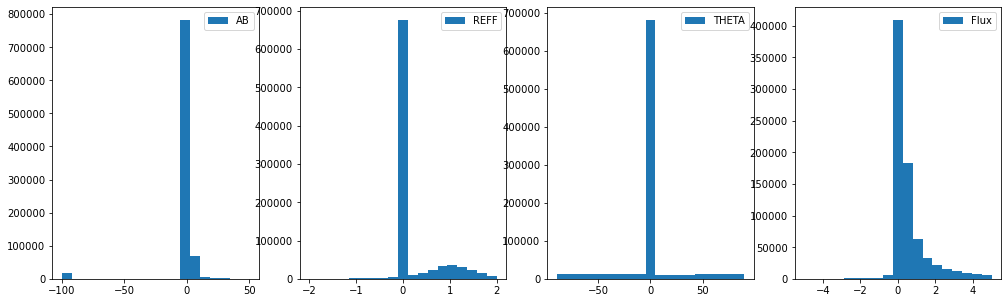

In [9]:
# First lets plot histograms of the parameters, to see what makes sense.
fig, ax = plt.subplots(ncols = 4, figsize=(17,5))

ax[0].hist(farmer_tab['AB'], bins=19, range=(-100,50), label='AB')
ax[1].hist(farmer_tab['REFF'], bins=19, range=(-2,2), label='REFF')
ax[2].hist(farmer_tab['THETA'], bins=19, range=(-90,90), label='THETA')
ax[3].hist(farmer_tab['IRAC_CH1_FLUX'], bins=19, range=(-5,5), label='Flux')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

plt.show()

The peaks at zero are because models that don't include a parameter will be assigned zero. There are a clump of values of AB = -99 which seems to be a signature of failed models, so these will be removed. Furthermore there are negative effective radii's which makes no sense, and are therefor removed. The flux cannot be negative either, and is therefor removed. Furthermore we put an upper limit on the flux, to get realistic models - this might not be entirely right, there can also be something of with the normalisation.


There are many values of REFF equal to zero. This makes no sense, and must therefor be when the model breaks down. There are many values of theta equal to zero as well, which is possible, however unlikely that so many values would be zero. We also see negative flux values, which make no sense. It seems there might also be an upper limit on the flux, let's check the maximum value:

In [10]:
print(max(farmer_tab['IRAC_CH1_FLUX']))


965639.222496535


This is ridiculously high. I saw an example from the Exponential Galaxies where a flux of 50 was enough to make the entire cutout white. This might be a problem with the parameters

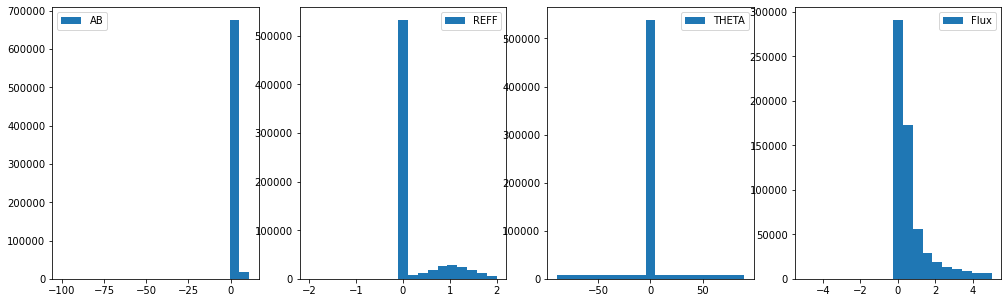

In [11]:
# Sanity checks
mask = (farmer_tab['AB'] != -99) & (farmer_tab['AB'] < 10) & (farmer_tab['REFF'] >= 0) \
        & (farmer_tab['IRAC_CH1_FLUX'] >= 0) #& (farmer_tab['IRAC_CH1_FLUX'] < 100) #flux below 40 before
true_tab = farmer_tab[mask]

fig, ax = plt.subplots(ncols = 4, figsize=(17,5))

ax[0].hist(true_tab['AB'], bins=19, range=(-100,11), label='AB')
ax[1].hist(true_tab['REFF'], bins=19, range=(-2,2), label='REFF')
ax[2].hist(true_tab['THETA'], bins=19, range=(-90,90), label='THETA')
ax[3].hist(true_tab['IRAC_CH1_FLUX'], bins=19, range=(-5,5), label='Flux')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

plt.show()

I seems when correcting the parameters AB and REFF, theta naturally becomes evenly distributed as expected.

# Extracting values from catalogue within the tile (image)

The farmer catalogue covers a lot more than just this tile, we therefor need to make a sub catalogue with only the galaxies wihtin the tile. More specifically we are interested in galaxies at least 103 pixels away from the border (so we can create a cutout the size of the PSF).

In [12]:
# Load information from the tile's header
w = WCS(header)

# Find pixel values in the image's corner (notice this is on the form x,y as in DS9 and not like imshow shows)
bottom_left = (104,104)
bottom_right = (np.shape(img)[1]-104, 104)
upper_left = (104, np.shape(img)[0]-104)
upper_right = (np.shape(img)[1]-104, np.shape(img)[0]-104)

# Find RA DEC coordinates for these
corners = [bottom_left, bottom_right, upper_left, upper_right]
sky_corners = []

for i in range(4):
    skycoord = w.pixel_to_world(*corners[i])
    print(skycoord)
    sky_corners.append(skycoord)    

<SkyCoord (ICRS): (ra, dec) in deg
    (150.2042837, 2.23047047)>
<SkyCoord (ICRS): (ra, dec) in deg
    (150.05967424, 2.23047201)>
<SkyCoord (ICRS): (ra, dec) in deg
    (150.20429086, 2.35180332)>
<SkyCoord (ICRS): (ra, dec) in deg
    (150.05966963, 2.35180494)>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


It was right to feed the coordinates to skycoords on the form x,y since the results matches that when we move upwards in the image declination increases and when we move rightwards the right ascension decreases. This corresponds with what we observe when opening the image in DS9.

In [13]:
# The interval of right ascension is thus:
ra_int = (150.05967424, 150.20429086)

# Declination interval
dec_int = (2.23047047, 2.35180494)

# Lets mask the "true catalogue" to create a new catalogue containing only sources within the image
mask = (true_tab['IRAC_1_ALPHA_J2000'] > ra_int[0]) & (true_tab['IRAC_1_ALPHA_J2000'] < ra_int[1]) \
        & (true_tab['IRAC_1_DELTA_J2000'] > dec_int[0]) & (true_tab['IRAC_1_DELTA_J2000'] < dec_int[1])
match_tab = true_tab[mask]

# Check how many objects are found
print(len(match_tab))

7173


# Checking that the models work

In [14]:
# Create function than can make a cutout the size of the PSF centered around the centroid
def create_cutout(cat_coord, size=207):
    
    # Convert RA DEC coordinates into pixel coordinates of the image
    cat_skycoord = SkyCoord(ra = cat_coord[0], dec = cat_coord[1], unit='deg', frame='fk5')
    x0,y0 = w.world_to_pixel(cat_skycoord)
    
    # Get frame limits
    half_size = size//2
    xlow, xhigh = int(np.round(x0) - half_size), int(np.round(x0) + half_size)
    ylow, yhigh = int(np.round(y0) - half_size), int(np.round(y0) + half_size)
    
    # Raise warning if to close to the edge
    if xlow < 0 or ylow < 0 or xhigh > np.shape(img)[1] or yhigh > np.shape(img)[0]:
        print('The source is to close to the border of the image to make a cutout')
        
    else: 
        cutout = img[ylow:yhigh+1, xlow:xhigh+1] # remember imshow plots (rows, columns) so we use [y,x] here
        return cutout

## Point Source Galaxies

In [42]:
# Define function that can extract the indices from the catalogue pertaining to a model type
def extract_cat(model_type, tab=match_tab):
    
    """
    Model type can be: PS, SG, EG, DG, CG for respectively Point Source, Simple Galaxy, Exponential Galaxy,
                       DeVaucouleur Galaxy and Composite Galaxy
    """
    
    # Find the right string that the model is called in the catalogue
    if model_type == 'PS': model_type = 'PointSource         '
    if model_type == 'SG': model_type = 'SimpleGalaxy        '
    if model_type == 'EG': model_type = 'ExpGalaxy           '
    if model_type == 'DG': model_type = 'DevGalaxy           '
    if model_type == 'CG': model_type = 'FixedCompositeGalaxy'
    
    # Create a masked that extracts the objects with that model type
    idx = (tab['SOLUTION_MODEL'] == model_type)
    
    # Return the catalogue masked to contain only the desired model types
    return tab[idx]

In [16]:
# Define a function able to mark the object on the cutout
def mark_obj(cat_coord, ax, size=207):
    
    # Convert RA DEC coordinates into pixel coordinates of the image
    cat_skycoord = SkyCoord(ra = cat_coord[0], dec = cat_coord[1], unit='deg', frame='fk5')
    x0, y0 = w.world_to_pixel(cat_skycoord)
    
    # Get frame limits
    half_size = size//2
    xlow = int(np.round(x0) - half_size)
    ylow = int(np.round(y0) - half_size)
    
    # Mark object with circle
    c = Circle(xy=(x0-xlow, y0-ylow), radius=10, linewidth=2)
    c.set_facecolor('none')
    c.set_edgecolor('red')
    ax.add_artist(c)

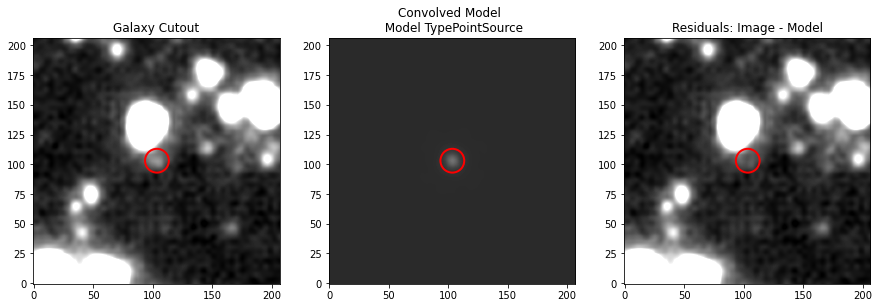

In [17]:
# Get point source catalogue
PS_tab = extract_cat('PS')

# Choose a source
index = 2506
coordinates = (PS_tab['IRAC_1_ALPHA_J2000'][index], PS_tab['IRAC_1_DELTA_J2000'][index])

# Get cutout
cutout = create_cutout(coordinates)

# Make model
PS_gal = Sersic_Model(PSF)
PS_gal.point_source(PS_tab['IRAC_CH1_FLUX'][index])

# Plot residuals
PS_gal.plot_residual(cutout)

# Mark object
mark_obj(coordinates, PS_gal.ax1)
mark_obj(coordinates, PS_gal.ax2)
mark_obj(coordinates, PS_gal.ax3)

## Simple Galaxies

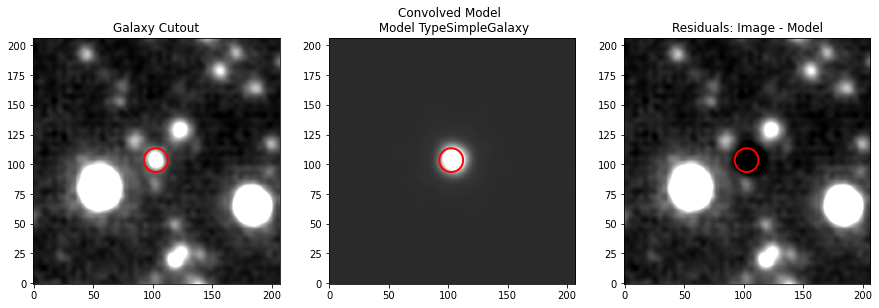

In [18]:
# get simple gal catalogue
SG_tab = extract_cat('SG')

# Choose a source
index = 42
coordinates = (SG_tab['IRAC_1_ALPHA_J2000'][index], SG_tab['IRAC_1_DELTA_J2000'][index])

# Get cutout
cutout = create_cutout(coordinates)

# Make model
SG_gal = Sersic_Model(PSF)
SG_gal.profile(solution_model='SimpleGalaxy', params=(104, 104, SG_tab['IRAC_CH1_FLUX'][index]))
SG_gal.convolve()
SG_gal.plot_residual(cutout)

# Mark object
mark_obj(coordinates, SG_gal.ax1)
mark_obj(coordinates, SG_gal.ax2)
mark_obj(coordinates, SG_gal.ax3)

## Exponential Galaxies

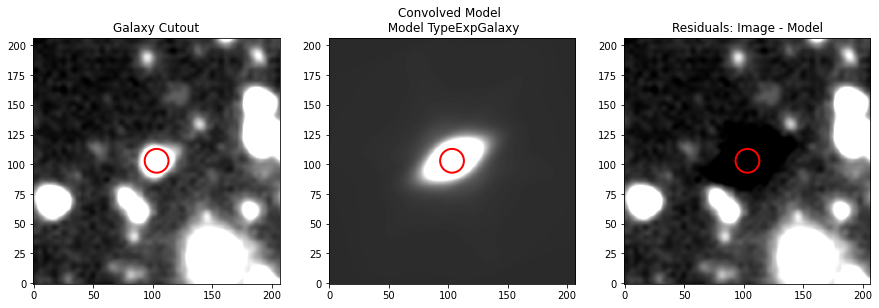

In [19]:
# Get expgal catalogue
EG_tab = extract_cat('EG')

# Choose a source
index = 504
coordinates = (EG_tab['IRAC_1_ALPHA_J2000'][index], EG_tab['IRAC_1_DELTA_J2000'][index])

# Get cutout
cutout = create_cutout(coordinates)

# Make model
EG_gal = Sersic_Model(PSF)
EG_gal.profile(solution_model='ExpGalaxy', params=(EG_tab['REFF'][index], 104, 104, EG_tab['AB'][index], \
                                                   EG_tab['THETA'][index], EG_tab['IRAC_CH1_FLUX'][index]))
EG_gal.convolve()
EG_gal.plot_residual(cutout)

# Mark object
mark_obj(coordinates, EG_gal.ax1)
mark_obj(coordinates, EG_gal.ax2)
mark_obj(coordinates, EG_gal.ax3)

## De Vaucouleur Galaxies

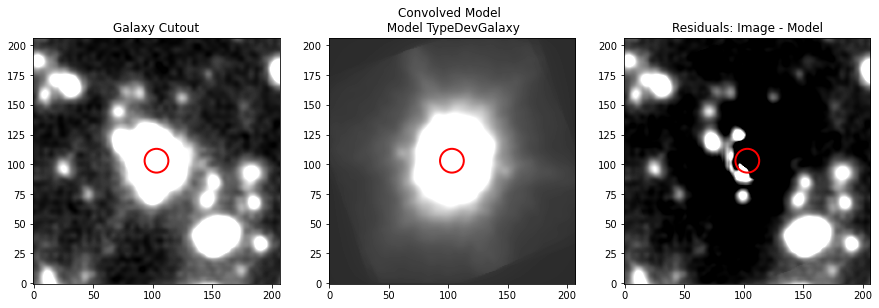

In [20]:
# Get expgal catalogue
DG_tab = extract_cat('DG')

# Choose a source
index = 32
coordinates = (DG_tab['IRAC_1_ALPHA_J2000'][index], DG_tab['IRAC_1_DELTA_J2000'][index])

# Get cutout
cutout = create_cutout(coordinates)

# Make model
DG_gal = Sersic_Model(PSF)
DG_gal.profile(solution_model='DevGalaxy', params=(DG_tab['REFF'][index], 104, 104, DG_tab['AB'][index], \
                                                   DG_tab['THETA'][index], DG_tab['IRAC_CH1_FLUX'][index]))
DG_gal.convolve()
DG_gal.plot_residual(cutout)

# Mark object
mark_obj(coordinates, DG_gal.ax1)
mark_obj(coordinates, DG_gal.ax2)
mark_obj(coordinates, DG_gal.ax3)

## Fixed Composite Galaxies

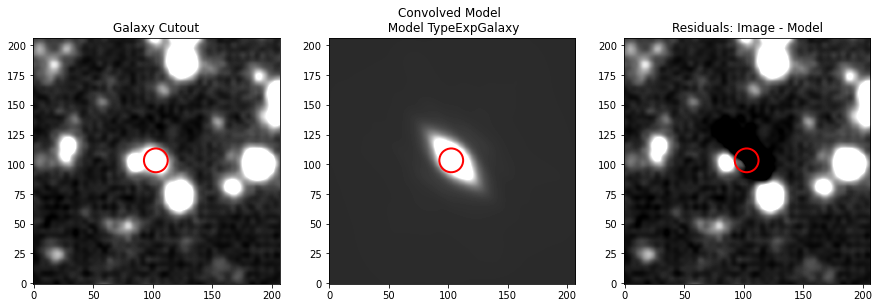

In [21]:
# Get expgal catalogue
CG_tab = extract_cat('CG')

# Choose a source
index = 32
coordinates = (CG_tab['IRAC_1_ALPHA_J2000'][index], CG_tab['IRAC_1_DELTA_J2000'][index])

# Get cutout
cutout = create_cutout(coordinates)

# Make model (we model it as if it was an exponential galaxy)
CG_gal = Sersic_Model(PSF)
CG_gal.profile(solution_model='ExpGalaxy', params=(CG_tab['EXP_REFF'][index], 104,104,CG_tab['EXP_AB'][index],\
                                                   CG_tab['EXP_THETA'][index], CG_tab['IRAC_CH1_FLUX'][index]))
CG_gal.convolve()
CG_gal.plot_residual(cutout)

# Mark object
mark_obj(coordinates, CG_gal.ax1)
mark_obj(coordinates, CG_gal.ax2)
mark_obj(coordinates, CG_gal.ax3)


# Figure displaying one of each models

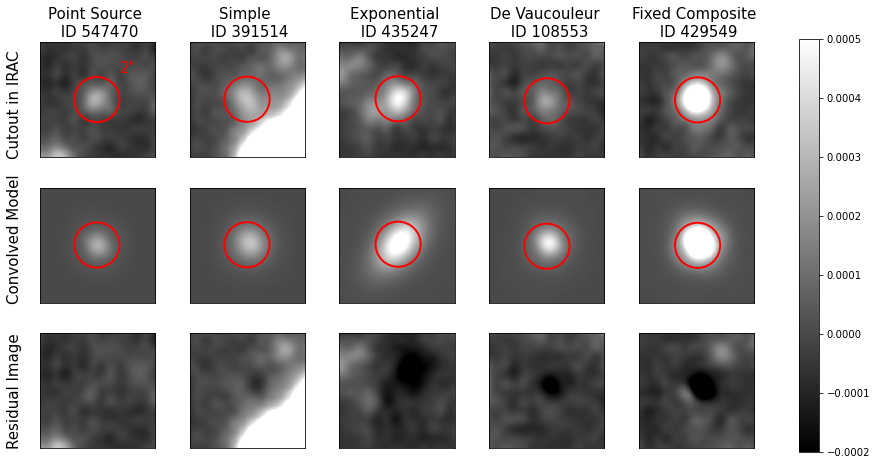

In [22]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(16,8), gridspec_kw={'wspace':0.3, 'hspace':0.01})
cutout_size = 51

# Plot Point Source Galaxy Example -------------------------------------------------------------

# Get information about source
PS_tab = extract_cat('PS')
index = np.argsort(PS_tab['IRAC_CH1_FLUX'])[4006]
coordinates = (PS_tab['IRAC_1_ALPHA_J2000'][index], PS_tab['IRAC_1_DELTA_J2000'][index])

# Cutout
cutout = create_cutout(coordinates, size=cutout_size)

# Make model
PS_gal = Sersic_Model(PSF)
PS_gal.point_source(PS_tab['IRAC_CH1_FLUX'][index], size=cutout_size)

# Plot it
im = ax[0,0].imshow(cutout, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[0,0], size=cutout_size)
ax[1,0].imshow(PS_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[1,0], size=cutout_size)
ax[2,0].imshow(cutout-PS_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)

# Add information to plot
ax[0,0].set_title('Point Source \n ID {}'.format(PS_tab['ID'][index]), fontsize=15)
ax[0,0].text(x=35, y=37, s='2\"', fontsize=15, color='red')


# Plot Simple Galaxy Example -------------------------------------------------------------

# Get information about source
SG_tab = extract_cat('SG')
index = np.argsort(SG_tab['IRAC_CH1_FLUX'])[46] #35, 40, 46, 47, 57
coordinates = (SG_tab['IRAC_1_ALPHA_J2000'][index], SG_tab['IRAC_1_DELTA_J2000'][index])

# Cutout
cutout = create_cutout(coordinates, size=cutout_size)

# Make model
SG_gal = Sersic_Model(PSF)
SG_gal.profile(solution_model='SimpleGalaxy', params=(104, 104, SG_tab['IRAC_CH1_FLUX'][index]), 
               size=cutout_size)
SG_gal.convolve(size=cutout_size)

# Plot it
ax[0,1].imshow(cutout, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[0,1], size=cutout_size)
ax[1,1].imshow(SG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[1,1], size=cutout_size)
ax[2,1].imshow(cutout-SG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)

# Add information to plot
ax[0,1].set_title('Simple \n ID {}'.format(SG_tab['ID'][index]), fontsize=15)


# Plot Exponential Galaxy Example -------------------------------------------------------------

# Get information about source
EG_tab = extract_cat('EG')
index = np.argsort(EG_tab['IRAC_CH1_FLUX'])[449] #470, 451, 449
coordinates = (EG_tab['IRAC_1_ALPHA_J2000'][index], EG_tab['IRAC_1_DELTA_J2000'][index])

# Cutout
cutout = create_cutout(coordinates, size=cutout_size)

# Make model
EG_gal = Sersic_Model(PSF)
EG_gal.profile(solution_model='ExpGalaxy', params=(EG_tab['REFF'][index], 104, 104, EG_tab['AB'][index], \
                                                   EG_tab['THETA'][index], EG_tab['IRAC_CH1_FLUX'][index]))
EG_gal.convolve(size=cutout_size)

# Plot it
ax[0,2].imshow(cutout, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[0,2], size=cutout_size)
ax[1,2].imshow(EG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[1,2], size=cutout_size)
ax[2,2].imshow(cutout-EG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)

# Add information to plot
ax[0,2].set_title('Exponential \n ID {}'.format(EG_tab['ID'][index]), fontsize=15)


# Plot De Vaucouleur Galaxy Example -------------------------------------------------------------

# Get information about source
DG_tab = extract_cat('DG')
index = np.argsort(DG_tab['IRAC_CH1_FLUX'])[40]
coordinates = (DG_tab['IRAC_1_ALPHA_J2000'][index], DG_tab['IRAC_1_DELTA_J2000'][index])

# Cutout
cutout = create_cutout(coordinates, size=cutout_size)

# Make model
DG_gal = Sersic_Model(PSF)
DG_gal.profile(solution_model='DevGalaxy', params=(DG_tab['REFF'][index], 104, 104, DG_tab['AB'][index], \
                                                   DG_tab['THETA'][index], DG_tab['IRAC_CH1_FLUX'][index]))
DG_gal.convolve(size=cutout_size)

# Plot it
ax[0,3].imshow(cutout, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[0,3], size=cutout_size)
ax[1,3].imshow(DG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[1,3], size=cutout_size)
ax[2,3].imshow(cutout-DG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)

# Add information to plot
ax[0,3].set_title('De Vaucouleur \n ID {}'.format(DG_tab['ID'][index]), fontsize=15)


# Plot Fixed Comosite Galaxy Example -------------------------------------------------------------

# Get information about source
CG_tab = extract_cat('CG')
index = np.argsort(CG_tab['IRAC_CH1_FLUX'])[33] #33, 27, 11
coordinates = (CG_tab['IRAC_1_ALPHA_J2000'][index], CG_tab['IRAC_1_DELTA_J2000'][index])

# Cutout
cutout = create_cutout(coordinates, size=cutout_size)

# Make model
CG_gal = Sersic_Model(PSF)
CG_gal.profile(solution_model='DevGalaxy', params=(DG_tab['REFF'][index], 104, 104, DG_tab['AB'][index], \
                                                   DG_tab['THETA'][index], DG_tab['IRAC_CH1_FLUX'][index]))
CG_gal.convolve(size=cutout_size)

# Plot it
ax[0,4].imshow(cutout, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[0,4], size=cutout_size)
ax[1,4].imshow(CG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)
mark_obj(coordinates, ax[1,4], size=cutout_size)
ax[2,4].imshow(cutout-CG_gal.model, cmap='gray', origin='lower', vmin=-2e-4, vmax=5e-4)

# Add information to plot
ax[0,4].set_title('Fixed Composite \n ID {}'.format(CG_tab['ID'][index]), fontsize=15)

# -----------------


# Add description of each row
ax[0,0].text(x=-15, y=0.5, s='Cutout in IRAC', fontsize=15, rotation='vertical')
ax[1,0].text(x=-15, y=0.5, s='Convolved Model', fontsize=15, rotation='vertical')
ax[2,0].text(x=-15, y=0.5, s='Residual Image', fontsize=15, rotation='vertical')

# Add colorbar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)

# Remove ticks
for i in range(3):
    for j in range(5):
        ax[i%5,j].set_xticks([])
        ax[i%5,j].set_yticks([])

# Save figure
plt.savefig('Saved_Figures/Model_cutouts.pdf', facecolor='w')

plt.show()

# Example of a bad model

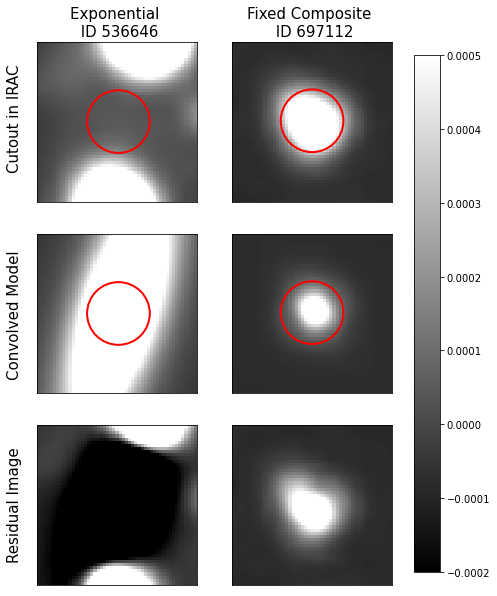

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,10))

# Plot Exponential Galaxy Example -------------------------------------------------------------

# Get information about source
EG_tab = extract_cat('EG')
index = np.argsort(EG_tab['IRAC_CH1_FLUX'])[1311] #1300
coordinates = (EG_tab['IRAC_1_ALPHA_J2000'][index], EG_tab['IRAC_1_DELTA_J2000'][index])

# Cutout
cutout = create_cutout(coordinates, size=cutout_size)

# Make model
EG_gal = Sersic_Model(PSF)
EG_gal.profile(solution_model='ExpGalaxy', params=(EG_tab['REFF'][index], 104, 104, EG_tab['AB'][index], \
                                                   EG_tab['THETA'][index], EG_tab['IRAC_CH1_FLUX'][index]))
EG_gal.convolve(size=cutout_size)

# Plot it
ax[0,0].imshow(cutout, cmap='gray', origin='lower', vmin=-1e-3, vmax=5e-3)
mark_obj(coordinates, ax[0,0], size=cutout_size)
ax[1,0].imshow(EG_gal.model, cmap='gray', origin='lower', vmin=-1e-3, vmax=5e-3)
mark_obj(coordinates, ax[1,0], size=cutout_size)
ax[2,0].imshow(cutout-EG_gal.model, cmap='gray', origin='lower', vmin=-1e-3, vmax=5e-3)

# Add information to plot
ax[0,0].set_title('Exponential \n ID {}'.format(EG_tab['ID'][index]), fontsize=15)


# Plot Fixed Comosite Galaxy Example -------------------------------------------------------------

# Get information about source
CG_tab = extract_cat('CG')
index = np.argsort(CG_tab['IRAC_CH1_FLUX'])[131] #101, 102, 105
coordinates = (CG_tab['IRAC_1_ALPHA_J2000'][index], CG_tab['IRAC_1_DELTA_J2000'][index])

# Cutout
cutout = create_cutout(coordinates, size=cutout_size)

# Make model
CG_gal = Sersic_Model(PSF)
CG_gal.profile(solution_model='DevGalaxy', params=(DG_tab['REFF'][index], 104, 104, DG_tab['AB'][index], \
                                                   DG_tab['THETA'][index], DG_tab['IRAC_CH1_FLUX'][index]))
CG_gal.convolve(size=cutout_size)

# Plot it
ax[0,1].imshow(cutout, cmap='gray', origin='lower', vmin=-1e-3, vmax=5e-3)
mark_obj(coordinates, ax[0,1], size=cutout_size)
ax[1,1].imshow(CG_gal.model, cmap='gray', origin='lower', vmin=-1e-3, vmax=5e-3)
mark_obj(coordinates, ax[1,1], size=cutout_size)
ax[2,1].imshow(cutout-CG_gal.model, cmap='gray', origin='lower', vmin=-1e-3, vmax=5e-3)

# Add information to plot
ax[0,1].set_title('Fixed Composite \n ID {}'.format(CG_tab['ID'][index]), fontsize=15)

# Add colorbar and labels
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
ax[0,0].text(x=-10, y=10, s='Cutout in IRAC', fontsize=15, rotation='vertical')
ax[1,0].text(x=-10, y=5, s='Convolved Model', fontsize=15, rotation='vertical')
ax[2,0].text(x=-10, y=8, s='Residual Image', fontsize=15, rotation='vertical')

# Remove ticks
for i in range(3):
    for j in range(2):
        ax[i%5,j].set_xticks([])
        ax[i%5,j].set_yticks([])

# Save figure
plt.savefig('Saved_Figures/BAD_model_cutouts.pdf', facecolor='w')

plt.show()

# Combined Model

In [24]:
# Helper function to get the placement of the cutout tht is modelled wihtin the big image
def get_ranges(cat_coord, w=w):
    
    # Convert RA DEC coordinates into pixel coordinates of the image
    cat_skycoord = SkyCoord(ra = cat_coord[0], dec = cat_coord[1], unit='deg', frame='fk5')
    x0, y0 = w.world_to_pixel(cat_skycoord)
    
    # Get frame limits
    xrange = ( int(np.round(x0) - 103), int(np.round(x0) + 103) )
    yrange = ( int(np.round(y0) - 103), int(np.round(y0) + 103) )
    
    return xrange, yrange

In [25]:
# Create empty matrix the size of the image (containing zeros) - this is where we will fill in the models
comb_model = np.zeros_like(img)

# Point Sources -----------------------------------------------------------------------------------------
print('Modelling Point Sources')
for i in tqdm(range(len(PS_tab))):
    
    # Get Ra Dec coordinates
    coordinates = (PS_tab['IRAC_1_ALPHA_J2000'][i], PS_tab['IRAC_1_DELTA_J2000'][i])
    
    # Make model
    PS = Sersic_Model(PSF)
    PS.point_source(PS_tab['IRAC_CH1_FLUX'][i])

    # Include the model in the combined model
    yra, xra = get_ranges(coordinates) #xy switched now
    
    try:
        comb_model[xra[0]:xra[1]+1, yra[0]:yra[1]+1] += PS.model
    except:
        print(f"Error at {i}")
# -------------------------------------------------------------------------------------------------------


# Simple Galaxy -----------------------------------------------------------------------------------------
print('Modelling Simple Galaxies')
for i in tqdm(range(len(SG_tab))):
    
    # Get Ra Dec coordinates
    coordinates = (SG_tab['IRAC_1_ALPHA_J2000'][i], SG_tab['IRAC_1_DELTA_J2000'][i])

    # Make model
    SG = Sersic_Model(PSF)
    SG.profile(solution_model='SimpleGalaxy', params=(104, 104, SG_tab['IRAC_CH1_FLUX'][i]))
    SG.convolve()

    # Include the model in the combined model
    yra, xra = get_ranges(coordinates)
    
    try:
        comb_model[xra[0]:xra[1]+1, yra[0]:yra[1]+1] += SG.model
    except:
        print(f"Error at {i}")
# -------------------------------------------------------------------------------------------------------



# Exponential Galaxy ------------------------------------------------------------------------------------
print('Modelling Exponential Galaxies')
for i in tqdm(range(len(EG_tab))):
    
    # Get Ra Dec coordinates
    coordinates = (EG_tab['IRAC_1_ALPHA_J2000'][i], EG_tab['IRAC_1_DELTA_J2000'][i])
    
    # Make model
    EG = Sersic_Model(PSF)
    EG.profile(solution_model='ExpGalaxy', params=(EG_tab['REFF'][i], 104, 104, EG_tab['AB'][i], \
                                                   EG_tab['THETA'][i], EG_tab['IRAC_CH1_FLUX'][i]))
    EG.convolve()

    # Include the model in the combined model
    yra, xra = get_ranges(coordinates)
    
    try:
        comb_model[xra[0]:xra[1]+1, yra[0]:yra[1]+1] += EG.model
    except:
        print(f"Error at {i}")
# -------------------------------------------------------------------------------------------------------



# De Vaucouleur Galaxy ----------------------------------------------------------------------------------
print('Modelling De Vaucouleur Galaxies')
for i in tqdm(range(len(DG_tab))):
    
    # Get Ra Dec coordinates
    coordinates = (DG_tab['IRAC_1_ALPHA_J2000'][i], DG_tab['IRAC_1_DELTA_J2000'][i])
    
    # Make model
    DG = Sersic_Model(PSF)
    DG.profile(solution_model='DevGalaxy', params=(DG_tab['REFF'][i], 104, 104, DG_tab['AB'][i], \
                                                   DG_tab['THETA'][i], DG_tab['IRAC_CH1_FLUX'][i]))
    DG.convolve()
    
    # Include the model in the combined model
    yra, xra = get_ranges(coordinates)
    
    try:
        comb_model[xra[0]:xra[1]+1, yra[0]:yra[1]+1] += DG.model
    except:
        print(f"Error at {i}")
# -------------------------------------------------------------------------------------------------------



# Fixed Composite Galaxy --------------------------------------------------------------------------------
print('Modelling Fixed Composite Galaxies')
for i in tqdm(range(len(CG_tab))):
    
    # Get Ra Dec coordinates
    coordinates = (CG_tab['IRAC_1_ALPHA_J2000'][i], CG_tab['IRAC_1_DELTA_J2000'][i])
    
    # Make model (we model it as if it was an exponential galaxy)
    CG = Sersic_Model(PSF)
    CG.profile(solution_model='ExpGalaxy', params=(CG_tab['EXP_REFF'][i], 104,104,CG_tab['EXP_AB'][i],\
                                                   CG_tab['EXP_THETA'][i], CG_tab['IRAC_CH1_FLUX'][i]))
    CG.convolve()

    # Include the model in the combined model
    yra, xra = get_ranges(coordinates)   
    try:
        comb_model[xra[0]:xra[1]+1, yra[0]:yra[1]+1] += CG.model
    except:
        print(f"Error at {i}")
# -------------------------------------------------------------------------------------------------------


Modelling Point Sources


  0%|          | 0/5209 [00:00<?, ?it/s]

Modelling Simple Galaxies


  0%|          | 0/131 [00:00<?, ?it/s]

Modelling Exponential Galaxies


  0%|          | 0/1350 [00:00<?, ?it/s]

Modelling De Vaucouleur Galaxies


  0%|          | 0/319 [00:00<?, ?it/s]

Modelling Fixed Composite Galaxies


  0%|          | 0/164 [00:00<?, ?it/s]

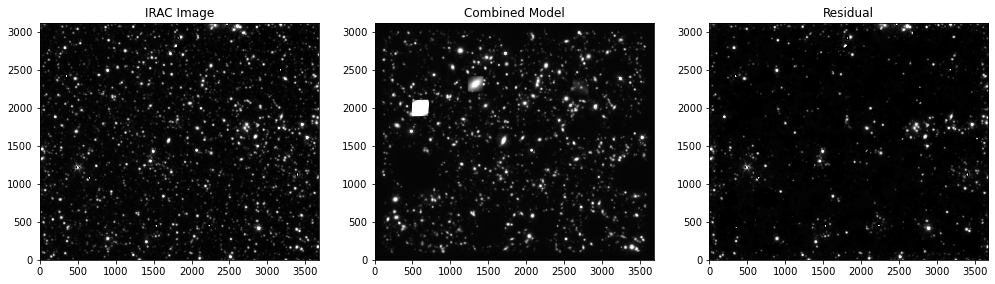

In [26]:
normal = simple_norm(img, stretch='asinh', percent=99.5)

fig, ax = plt.subplots(ncols=3, figsize=(17,5))

ax[0].imshow(img, cmap='gray', origin='lower', norm = normal)
ax[0].set_title('IRAC Image')

ax[1].imshow(comb_model, cmap='gray', origin='lower', norm = normal)
ax[1].set_title('Combined Model')

ax[2].imshow(img-comb_model, cmap='gray', origin='lower', norm = normal)
ax[2].set_title('Residual')

plt.show()

It is clear from the residual map that there is still a lot of patches full of stars yet. This is due to the masks and due to a lot of models having to be removed due to ilogical parameters. Next step would probably be to try and model these with a point source model instead.

# Statistics of the modelling

Lets provide some numbers of what we have done:

First of all whichs tabs contain what:
- Farmer tab: all information
- True tab: removed objects with ilogical values
- Match tab: removed objects outside the tile

In [41]:
# Change the order so we can start by reporting the number of sources wihtin the tile
# Load information from the tile's header
w = WCS(header)

# Find pixel values in the image's corner (notice this is on the form x,y as in DS9 and not like imshow shows)
bottom_left = (104,104)
bottom_right = (np.shape(img)[1]-104, 104)
upper_left = (104, np.shape(img)[0]-104)
upper_right = (np.shape(img)[1]-104, np.shape(img)[0]-104)

# Find RA DEC coordinates for these
corners = [bottom_left, bottom_right, upper_left, upper_right]
sky_corners = []

for i in range(4):
    skycoord = w.pixel_to_world(*corners[i])
    print(skycoord)
    sky_corners.append(skycoord) 
    
# The interval of right ascension is thus:
ra_int = (150.05967424, 150.20429086)

# Declination interval
dec_int = (2.23047047, 2.35180494)

# Lets mask the "true catalogue" to create a new catalogue containing only sources within the image
mask = (farmer_tab['IRAC_1_ALPHA_J2000'] > ra_int[0]) & (farmer_tab['IRAC_1_ALPHA_J2000'] < ra_int[1]) \
        & (farmer_tab['IRAC_1_DELTA_J2000'] > dec_int[0]) & (farmer_tab['IRAC_1_DELTA_J2000'] < dec_int[1])
tile_tab = farmer_tab[mask]

# Check how many objects are found
print(f'Total in farmer: {len(farmer_tab)}, total wihtin tile: {len(tile_tab)}')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (ICRS): (ra, dec) in deg
    (150.2042837, 2.23047047)>
<SkyCoord (ICRS): (ra, dec) in deg
    (150.05967424, 2.23047201)>
<SkyCoord (ICRS): (ra, dec) in deg
    (150.20429086, 2.35180332)>
<SkyCoord (ICRS): (ra, dec) in deg
    (150.05966963, 2.35180494)>
Total in farmer: 893793, total wihtin tile: 9500


In [45]:
# Number of each model wihtin the tile (no selection)

#Point source
PS_tile = extract_cat('PS', tab=tile_tab)
print(f'PS within tile: {len(PS_tile)}')

# simple galaxy
SG_tile = extract_cat('SG', tab=tile_tab)
print(f'SG within tile: {len(SG_tile)}')

# exp galaxy
EG_tile = extract_cat('EG', tab=tile_tab)
print(f'EG within tile: {len(EG_tile)}')

# dev galaxy
DG_tile = extract_cat('DG', tab=tile_tab)
print(f'DG within tile: {len(DG_tile)}')

# composite galaxy
CG_tile = extract_cat('CG', tab=tile_tab)
print(f'CG within tile: {len(CG_tile)}')

PS within tile: 6844
SG within tile: 188
EG within tile: 1782
DG within tile: 517
CG within tile: 169


In [50]:
# Select what would correspond to the selection we made to make true_tab. This removes illogical parameters
mask = (tile_tab['AB'] != -99) & (tile_tab['AB'] < 10) & (tile_tab['REFF'] >= 0) \
        & (tile_tab['IRAC_CH1_FLUX'] >= 0) #& (farmer_tab['IRAC_CH1_FLUX'] < 100) #flux below 40 before

sanity_tab = tile_tab[mask]
print(len(sanity_tab))

7173


In [49]:
# Number of each model left after sanity check

#Point source
PS_sanity = extract_cat('PS', tab=sanity_tab)
print(f'PS within tile: {len(PS_sanity)}')

# simple galaxy
SG_sanity = extract_cat('SG', tab=sanity_tab)
print(f'SG within tile: {len(SG_sanity)}')

# exp galaxy
EG_sanity = extract_cat('EG', tab=sanity_tab)
print(f'EG within tile: {len(EG_sanity)}')

# dev galaxy
DG_sanity = extract_cat('DG', tab=sanity_tab)
print(f'DG within tile: {len(DG_sanity)}')

# composite galaxy
CG_sanity = extract_cat('CG', tab=sanity_tab)
print(f'CG within tile: {len(CG_sanity)}')

PS within tile: 5209
SG within tile: 131
EG within tile: 1350
DG within tile: 319
CG within tile: 164


In [63]:
# Number of those that are flagged in FLAG_COMBINED (tehre is not a flag column for IRAC)

PS_flags = np.sum(PS_sanity['FLAG_COMBINED'])
print(f' PS sanity flagged: {PS_flags}')

SG_flags = np.sum(SG_sanity['FLAG_COMBINED'])
print(f' SG sanity flagged: {SG_flags}')

EG_flags = np.sum(EG_sanity['FLAG_COMBINED'])
print(f' EG sanity flagged: {EG_flags}')

DG_flags = np.sum(DG_sanity['FLAG_COMBINED'])
print(f' DG sanity flagged: {DG_flags}')

CG_flags = np.sum(CG_sanity['FLAG_COMBINED'])
print(f' CG sanity flagged: {CG_flags}')

# total
np.sum(sanity_tab['FLAG_COMBINED'])

 PS sanity flagged: 69
 SG sanity flagged: 6
 EG sanity flagged: 17
 DG sanity flagged: 17
 CG sanity flagged: 0


109

# Debugging notes

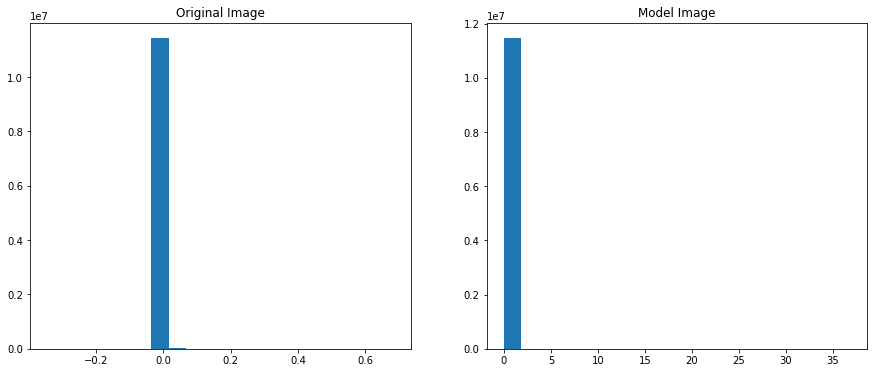

In [27]:
# Comparing histograms of original image and model image to see if there is significant differences
fig, ax = plt.subplots(ncols=2, figsize=(15,6))

ax[0].hist(img.flatten(), bins=20)
ax[1].hist(comb_model.flatten(), bins=20)

#ax[0].set_ylim(0,200)
#ax[1].set_ylim(0,200)

ax[0].set_title('Original Image')
ax[1].set_title('Model Image')

plt.show()

It seems there is probably something of with the normalisation, since the original image spans up to 0.7 and the model image only a lot higher. As we saw previously there were some bery high fluxes in the catalogue that are probably a little off. This is likely what produces the difference in the histograms.

In [28]:
# Create fits file with model
hdu = fits.PrimaryHDU(comb_model, header)
hdu.writeto('Saved_Results/Combined_model_IRAC_tile7_7.fits', overwrite=True)

hdu = fits.PrimaryHDU(img-comb_model, header)
hdu.writeto('Saved_Results/Residual_map_IRAC_tile7_7.fits', overwrite=True)

Lets check whether the problem is the models we remove because they are pathological!!

In [29]:
# The interval of right ascension is thus:
ra_int = (150.05967424, 150.20429086)

# Declination interval
dec_int = (2.23047047, 2.35180494)

# LEts mask Johns catalogue (original) to contain only those within image
mask2 = (farmer_tab['IRAC_1_ALPHA_J2000'] > ra_int[0]) & (farmer_tab['IRAC_1_ALPHA_J2000'] < ra_int[1]) \
        & (farmer_tab['IRAC_1_DELTA_J2000'] > dec_int[0]) & (farmer_tab['IRAC_1_DELTA_J2000'] < dec_int[1])
all_tab = farmer_tab[mask2]

In [30]:
len(all_tab)-len(match_tab)

2327

In [31]:
# Only removed models
mask = (all_tab['AB'] != -99) & (all_tab['AB'] < 10) & (all_tab['REFF'] >= 0) \
        & (all_tab['IRAC_CH1_FLUX'] >= 0) #& (all_tab['IRAC_CH1_FLUX'] < 40)

removed_tab = all_tab[~mask]

len(removed_tab)

2327

There are therefor 2000 objects we are leaving out when creating the combined_mode.

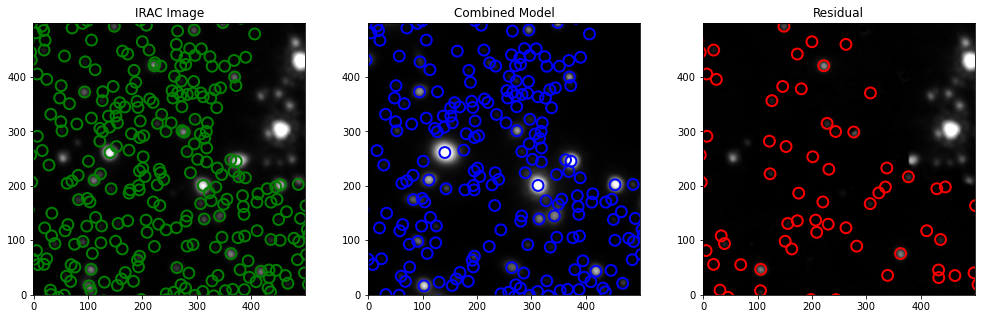

In [32]:
# Zoom in on a corner
zoom_img = img[1000:1500,1000:1500]
zoom_mod = comb_model[1000:1500,1000:1500]


normal = simple_norm(zoom_img, stretch='asinh', percent=99.5)

fig, ax = plt.subplots(ncols=3, figsize=(17,5))

ax[0].imshow(zoom_img, cmap='gray', origin='lower', norm = normal)
ax[0].set_title('IRAC Image')

normal2 = simple_norm(zoom_mod, stretch='asinh', percent=99.5)
ax[1].imshow(zoom_mod, cmap='gray', origin='lower', norm = normal2)
ax[1].set_title('Combined Model')

ax[2].imshow(zoom_img-zoom_mod, cmap='gray', origin='lower', norm = normal)
ax[2].set_title('Residual')

# In green mark all models
for i in range(len(all_tab)):
               
    cat_skycoord = SkyCoord(ra = all_tab['IRAC_1_ALPHA_J2000'][i], dec = all_tab['IRAC_1_DELTA_J2000'][i], unit='deg', frame='fk5')
    x0, y0 = w.world_to_pixel(cat_skycoord)
               
    c = Circle(xy=(x0-1000,y0-1000), radius=10, linewidth=2)
    c.set_facecolor('none')
    c.set_edgecolor('green')
    ax[0].add_artist(c)


# In blue mark models used               
for i in range(len(match_tab)):
               
    cat_skycoord = SkyCoord(ra = match_tab['IRAC_1_ALPHA_J2000'][i], dec = match_tab['IRAC_1_DELTA_J2000'][i], unit='deg', frame='fk5')
    x0, y0 = w.world_to_pixel(cat_skycoord)
               
    c = Circle(xy=(x0-1000,y0-1000), radius=10, linewidth=2)
    c.set_facecolor('none')
    c.set_edgecolor('blue')
    ax[1].add_artist(c)
    
    
# In red mark objects we did not use             
for i in range(len(removed_tab)):
               
    cat_skycoord = SkyCoord(ra = removed_tab['IRAC_1_ALPHA_J2000'][i], dec = removed_tab['IRAC_1_DELTA_J2000'][i], unit='deg', frame='fk5')
    x0, y0 = w.world_to_pixel(cat_skycoord)
               
    c = Circle(xy=(x0-1000,y0-1000), radius=10, linewidth=2)
    c.set_facecolor('none')
    c.set_edgecolor('red')
    ax[2].add_artist(c)
    
    
plt.show()

okay seems like this might be the problem. LEts make a catalogue with only the removed models and mark those on the full residual image.

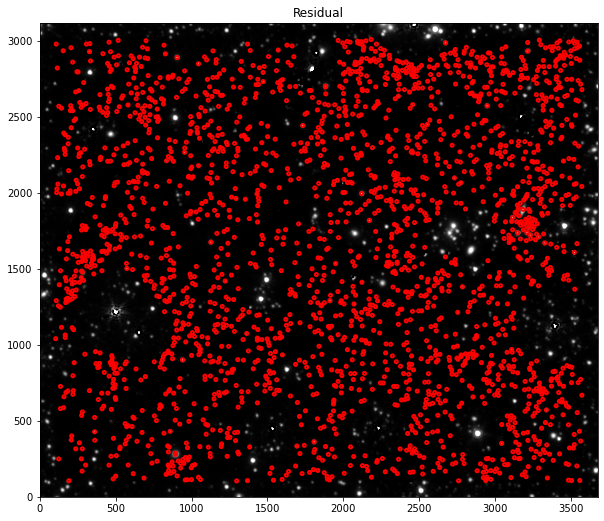

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(img-comb_model, cmap='gray', origin='lower', norm = normal)
ax.set_title('Residual')

# In red mark objects we did not use               
for i in range(len(removed_tab)):
               
    cat_skycoord = SkyCoord(ra = removed_tab['IRAC_1_ALPHA_J2000'][i], dec = removed_tab['IRAC_1_DELTA_J2000'][i], unit='deg', frame='fk5')
    x0, y0 = w.world_to_pixel(cat_skycoord)
               
    c = Circle(xy=(x0,y0), radius=10, linewidth=2)
    c.set_facecolor('none')
    c.set_edgecolor('red')
    ax.add_artist(c)
    
plt.show()
